In [2]:
from pathlib import Path
import zipfile
import h5py
import csv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
import sklearn


def PhaseModel(n_channel, coordinates, roll=-14):
    ant_angles = np.arange(0, 360, 360//n_channel)

    x_array = 0.1 * np.cos(np.radians(ant_angles))
    y_array = 0.1 * np.sin(np.radians(ant_angles))
    x_coord, y_coord = coordinates[:, 0], coordinates[:, 1]

    d = np.sqrt(
        (x_array[:, np.newaxis] - x_coord[np.newaxis, :]) ** 2
        + (y_array[:, np.newaxis] - y_coord[np.newaxis, :]) ** 2
        )
    arctan = np.arctan2(
        y_array[:, np.newaxis] - y_coord[np.newaxis, :],
        x_array[:, np.newaxis] - x_coord[np.newaxis, :]
        )

    spatial = 2*np.pi * d[:, :, np.newaxis] / 0.01163
    phase = np.unwrap(np.roll(spatial-arctan[:, :, np.newaxis], roll, axis=0), axis=0)
    #phase = np.unwrap(np.roll(spatial-arctan[:, :, np.newaxis], roll, axis=0), axis=0)
    phase -= phase[0, :, :][np.newaxis, :, :]
    
    return -phase

def phase_offset_correction(data_phases, model_phases, find_peak_height=0.5, find_peak_prom=0.3):
    
    phase_diff = data_phases-model_phases
    phase_diff = np.convolve(phase_diff, np.ones(5)/5, mode='valid')
    phase_diff_diff = np.convolve(np.diff(phase_diff), np.ones(5)/5, mode='same')
    peaks = signal.find_peaks(abs(phase_diff_diff), height=find_peak_height, prominence=find_peak_prom)
    #print(peaks)
    peak_inds = peaks[0]
    #print(peak_inds)
    peak_heights = peaks[1]['peak_heights']
    phase_correction = np.zeros(data_phases.size)
    n = 1
    for j in range(peak_inds.size):
        ind_j = peak_inds[j]
        if peak_inds.size == 1:
            approximate_discont_size = np.mean(phase_diff[ind_j+3:]) - np.mean(phase_diff[0:ind_j+3])
            n = np.round(approximate_discont_size/(2*np.pi), 0)
            phase_correction[ind_j+3:] += -1*2*n*np.pi
        elif peak_inds.size > 1:
            if j == 0: # first peak
                approximate_discont_size = np.mean(
                    phase_diff[ind_j+3:peak_inds[j+1]]+3) - np.mean(phase_diff[0:ind_j+3])
                n = np.round(approximate_discont_size/(2*np.pi), 0)
                #print(n)
                phase_correction[ind_j+3:] += -1*2*n*np.pi
            elif j == peak_inds.size - 1: # last peak
                approximate_discont_size = np.mean(
                    phase_diff[ind_j+3:]) - np.mean(phase_diff[peak_inds[j-1]+3:ind_j+3])
                n = np.round(approximate_discont_size/(2*np.pi), 0)
                #print(n)
                phase_correction[ind_j+3:] += -1*2*n*np.pi
            else: # intermediate peaks
                approximate_discont_size = np.mean(
                    phase_diff[ind_j+3:peak_inds[j+1]+3]) - np.mean(phase_diff[peak_inds[j-1]+3:ind_j+3])
                n = np.round(approximate_discont_size/(2*np.pi), 0)
                phase_correction[ind_j+3:] += -1*2*n*np.pi

    return phase_correction          


# develop phase corrections for phase difference distributions

In [3]:
jugaad_data = Path.home()/'iCloud'/'jugaad_data'/'Characterization'/'data.h5'
jugaad_data = h5py.File(jugaad_data, 'r')


In [4]:
test_key = 'r10z35'

test_data = jugaad_data[test_key][:]
print(test_data.shape)

(60, 141, 2, 2)


In [5]:
sns.set_theme(context='talk', style='whitegrid', font_scale=1.2)

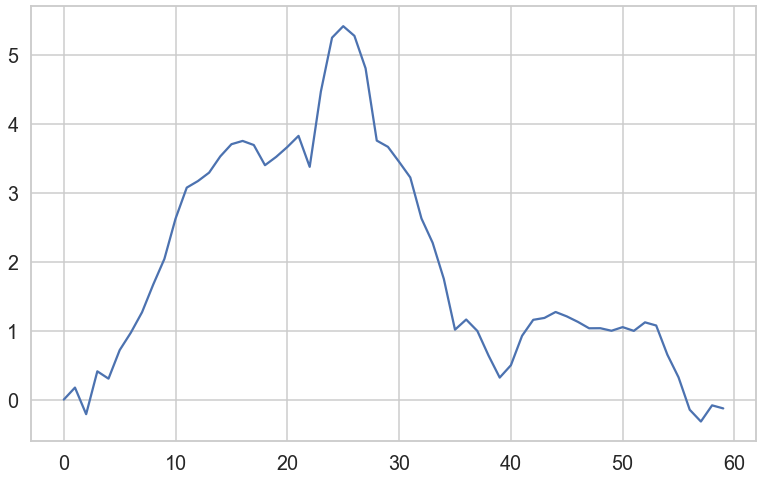

In [6]:
test_phases = np.unwrap(np.angle(test_data[:,:,1,0]), axis=0)
test_phases -= test_phases[0, :]
test_phases = test_phases.mean(axis=-1)

fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1,1,1)
ax.plot(test_phases)

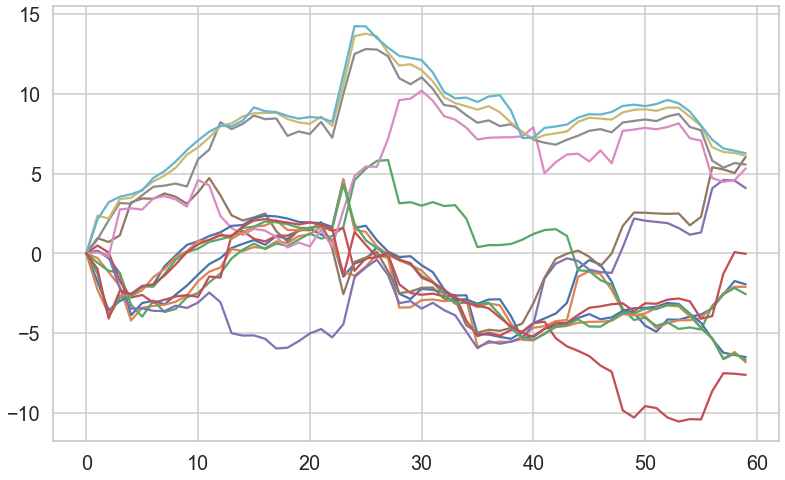

In [7]:
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1,1,1)

for i in np.arange(0, 140, 10):

    test_phases = np.unwrap(np.angle(test_data[:,i,1,0]), axis=0)
    test_phases -= test_phases[0]
    #test_phases = test_phases.mean(axis=-1)

    ax.plot(test_phases)

In [8]:
test_position = np.array([[0.010, 0.],])
PhaseModel(60, test_position, roll=-14).shape

(60, 1, 1)

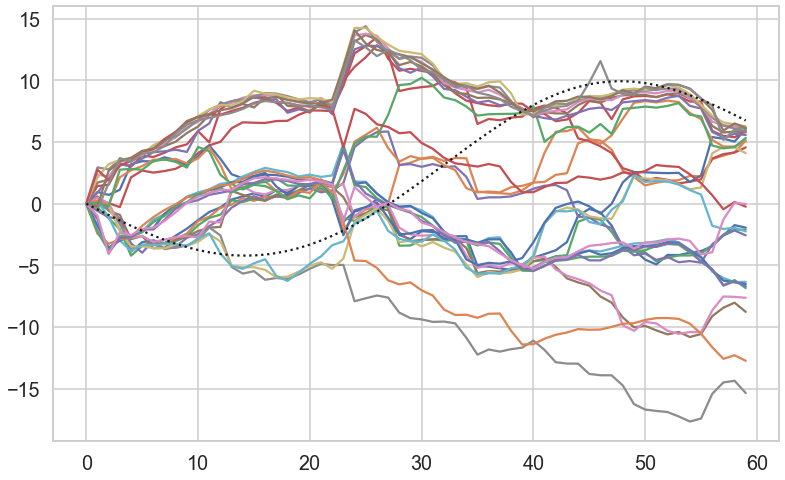

In [9]:
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1,1,1)

for i in np.arange(0, 140, 5):

    test_phases = np.unwrap(np.angle(test_data[:,i,1,0]), axis=0)
    test_phases -= test_phases[0]
    #test_phases = test_phases.mean(axis=-1)

    ax.plot(test_phases)

ax.plot(PhaseModel(60, test_position,)[:,0,0], color='k', ls=':')

In [10]:
(4 * np.pi - 0.7*np.pi) / (2 * np.pi)

1.65

In [11]:
test_phases.shape

(60,)

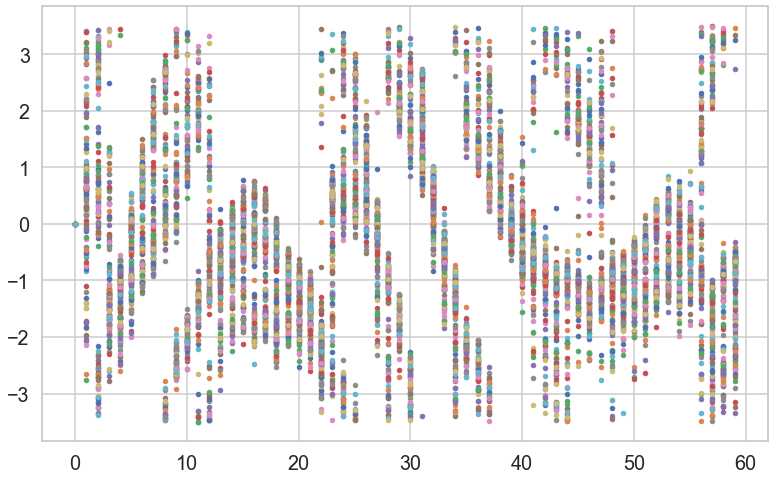

In [12]:
fig1 = plt.figure(figsize=(13,8))
#fig2 = plt.figure(figsize=(13,8))
ax1 = fig1.add_subplot(1,1,1)
#ax2 = fig2.add_subplot(1,1,1)

clist = sns.color_palette('deep', n_colors=10)
phase_errors = np.zeros(test_data.shape[0:2])

for i, n in enumerate(np.arange(0,140,1)):

    test_phases = np.unwrap(np.angle(test_data[:,n,1,0]), axis=0)
    test_phases -= test_phases[0]
    

    phase_correction = phase_offset_correction(test_phases, PhaseModel(60, test_position)[:,0,0])
    test_phases = test_phases + phase_correction
    phase_correction = phase_offset_correction(test_phases, PhaseModel(60, test_position)[:,0,0])
    test_phases = test_phases + phase_correction
    phase_correction = phase_offset_correction(test_phases, PhaseModel(60, test_position)[:,0,0])
    test_phases = test_phases + phase_correction
    
    differences = test_phases - PhaseModel(60, test_position)[:,0,0]
    for j in range(differences.size):
        if abs(differences[j]) > 3.5:
            while(abs(differences[j]) > 3.5):
                differences[j] -= np.sign(differences[j])*2*np.pi
    
    #if abs(test_phases.mean() > np.pi):
    #    test_phases -= test_phases.mean()
    #print(phase_correction)
    #difference = test_phases - PhaseModel(60, test_position)[:, 0, 0]
    #for j in range(difference.size):
    #    if abs(difference[j]/np.pi) > 1.0:
    #        if difference[j] < 0:
    #            while (difference[j]/np.pi) < -1.0:
    #                difference[j] += 2*np.pi
    #        if difference[j] > 0:
    #            while (difference[j]/np.pi) > 1.0:
    #                difference[j] -= 2*np.pi

    ax1.plot(differences, '.', color=clist[i%10])
    #ax1.set_ylim(-1,1)
    #ax1.plot(test_phases-PhaseModel(60, test_position)[:,0,0], '.', color=clist[i%10])
    #test_diff = np.convolve(test_phases-PhaseModel(60, test_position)[:,0,0], np.ones(5)/5, mode='valid')
    #ax.plot(test_phases-PhaseModel(60, test_position)[:,0,0], '.')
    #ax2.plot(test_diff, '.', color=clist[i])
    #ax2.plot(np.convolve(np.gradient(test_diff), np.ones(5)/5, mode='same'), '.', color=clist[i])
    #phase_errors[:, i] = difference
#ax1.plot(PhaseModel(60,test_position)[:,0,0])
#ax.plot(np.mean(phase_errors, axis=-1), color='k')

# Visualize Phase Differences

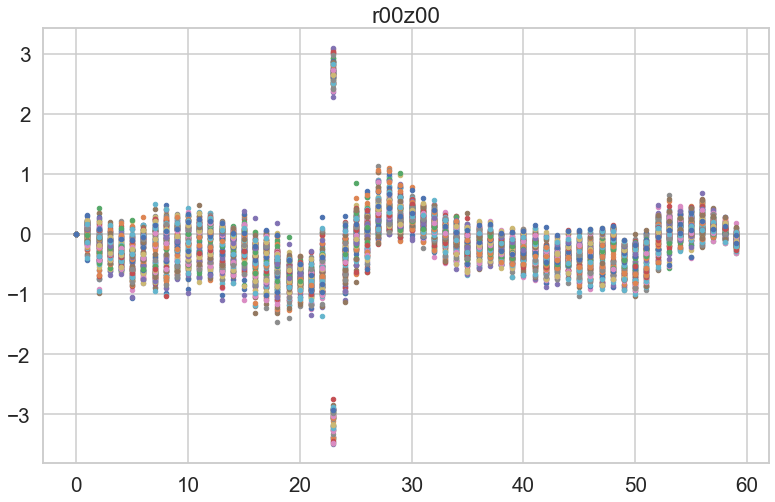

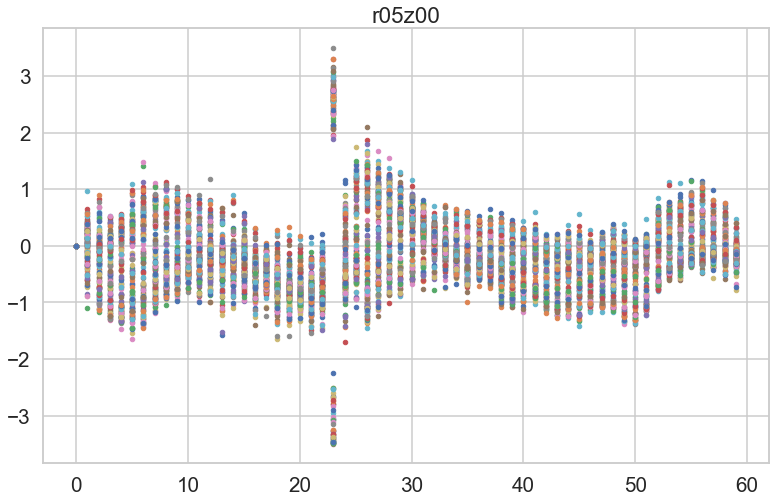

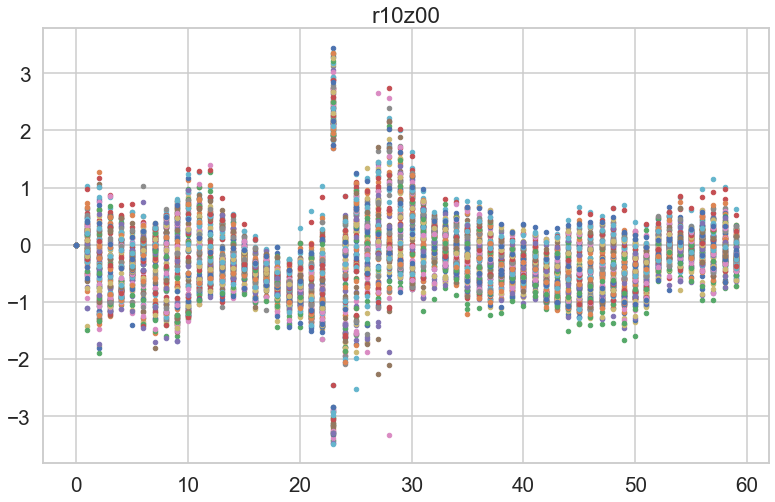

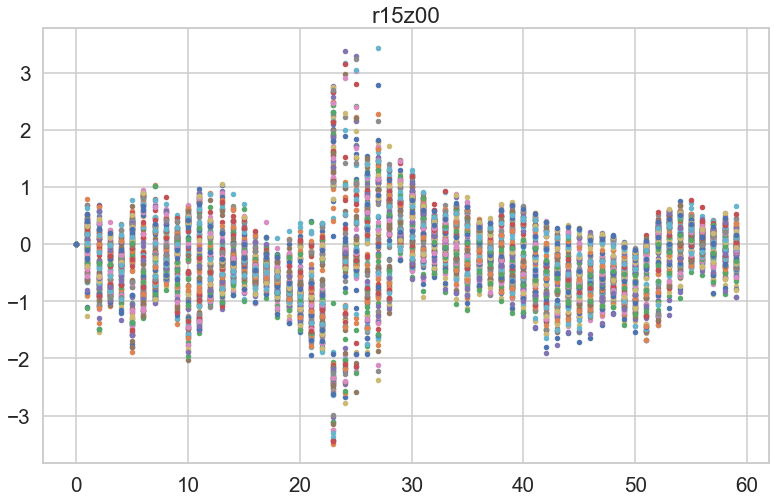

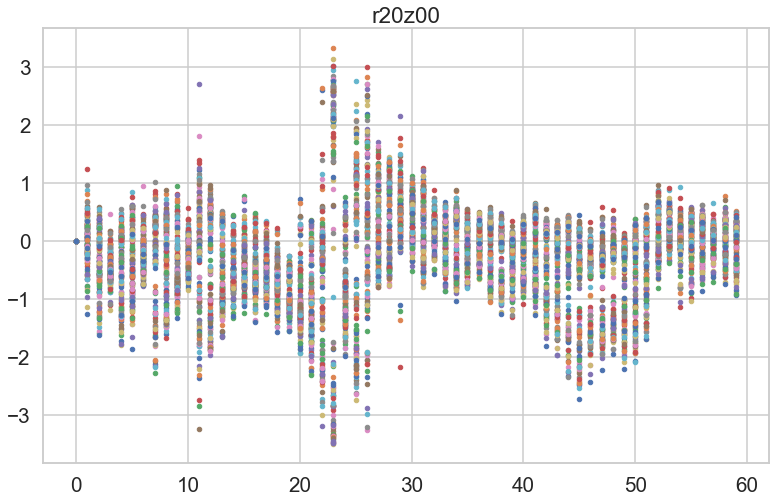

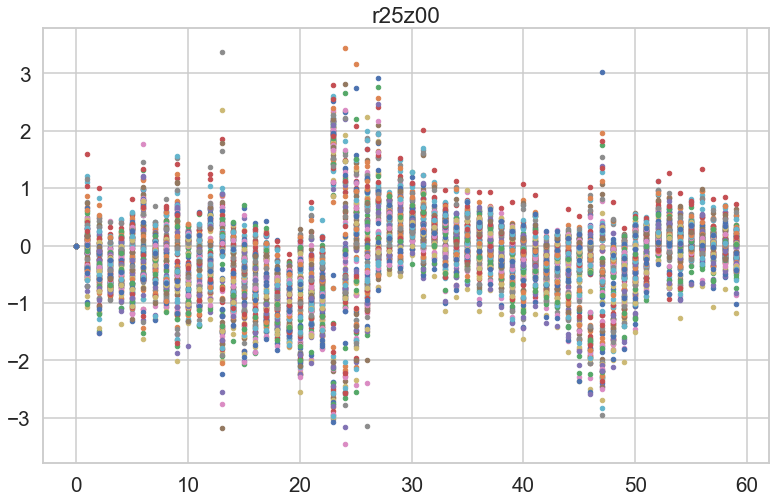

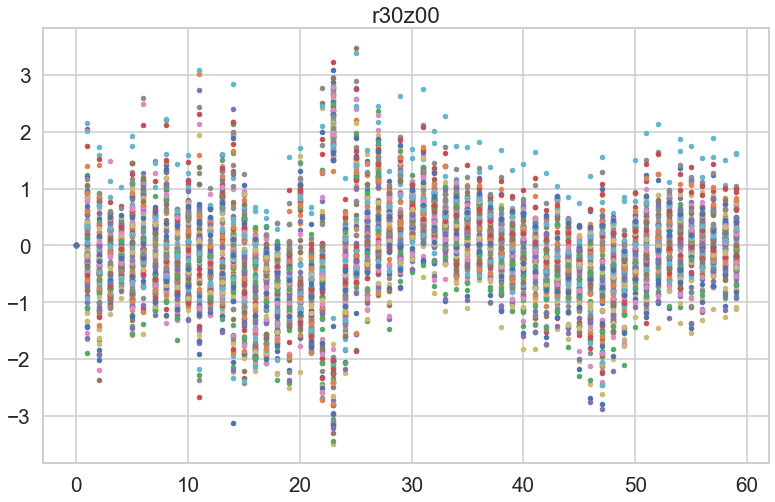

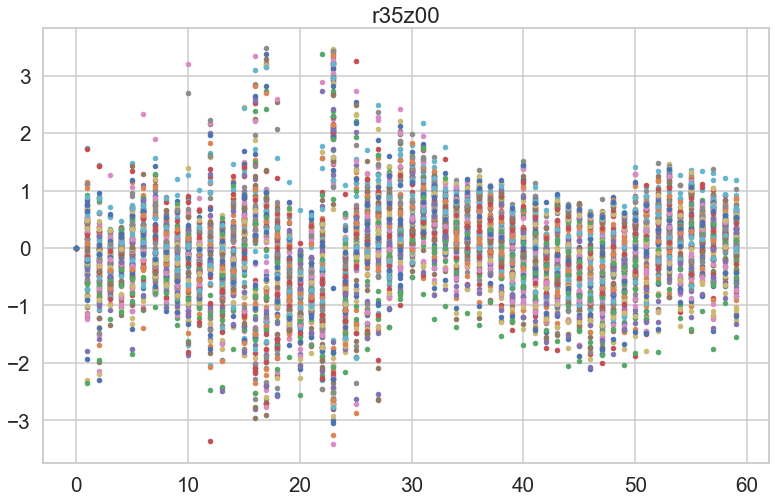

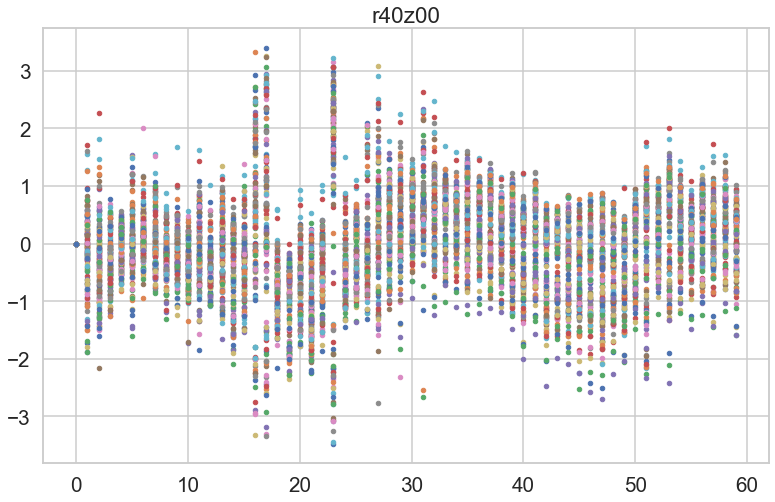

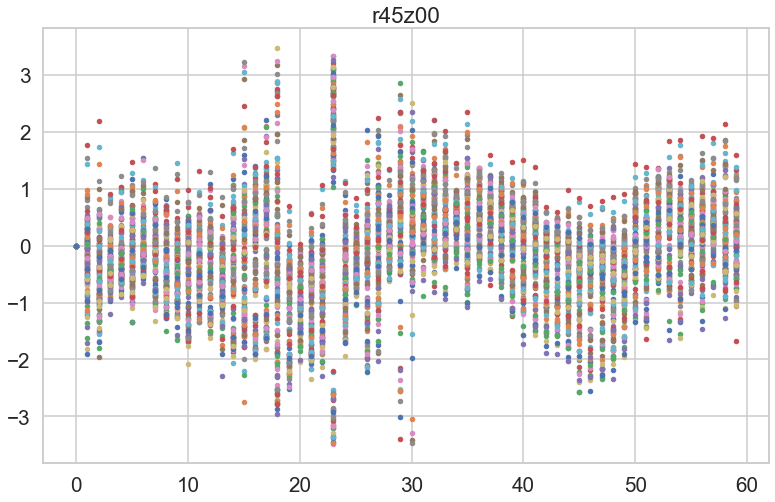

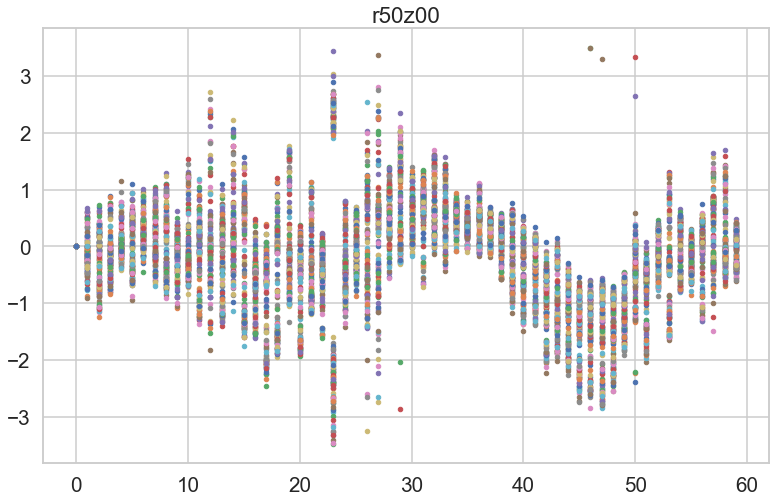

In [13]:
radii = np.arange(0, 55, 5)
test_axial_position = 0

clist = sns.color_palette('deep', n_colors=10)
sns.set_theme(context='talk', style='whitegrid', font_scale=1.25)

for rad in radii:
    fig = plt.figure(figsize=(13,8))
    ax = fig.add_subplot(1,1,1)
    
    if rad<10:
        test_key_rad = f'r0{rad}'
    else:
        test_key_rad = f'r{rad}'
    
    if test_axial_position < 10:
        test_key_axial = f'z0{test_axial_position}'
    else:
        test_key_axial = f'z{test_axial_position}'
        
    test_key = test_key_rad + test_key_axial
    test_data = jugaad_data[test_key][:]
    test_position = np.array([[0.001 * rad, 0.],])
    # loop over frequencies
    for i, n in enumerate(np.arange(0,test_data.shape[1],1)):

        test_phases = np.unwrap(np.angle(test_data[:,n,1,0]), axis=0)
        test_phases -= test_phases[0]


        phase_correction = phase_offset_correction(test_phases, PhaseModel(60, test_position)[:,0,0])
        test_phases = test_phases + phase_correction
        phase_correction = phase_offset_correction(test_phases, PhaseModel(60, test_position)[:,0,0])
        test_phases = test_phases + phase_correction
        phase_correction = phase_offset_correction(test_phases, PhaseModel(60, test_position)[:,0,0])
        test_phases = test_phases + phase_correction

        differences = test_phases - PhaseModel(60, test_position)[:,0,0]
        for j in range(differences.size):
            if abs(differences[j]) > 3.5:
                while(abs(differences[j]) > 3.5):
                    differences[j] -= np.sign(differences[j])*2*np.pi

        #if abs(test_phases.mean() > np.pi):
        #    test_phases -= test_phases.mean()
        #print(phase_correction)
        #difference = test_phases - PhaseModel(60, test_position)[:, 0, 0]
        #for j in range(difference.size):
        #    if abs(difference[j]/np.pi) > 1.0:
        #        if difference[j] < 0:
        #            while (difference[j]/np.pi) < -1.0:
        #                difference[j] += 2*np.pi
        #        if difference[j] > 0:
        #            while (difference[j]/np.pi) > 1.0:
        #                difference[j] -= 2*np.pi

        ax.plot(differences, '.', color=clist[i%10])
        
    ax.set_title(test_key)
    #ax.plot(PhaseModel(60, test_position)[:,0,0], 'k:')

# Visualize for a single frequency, the comparison between the measure phases and simulation

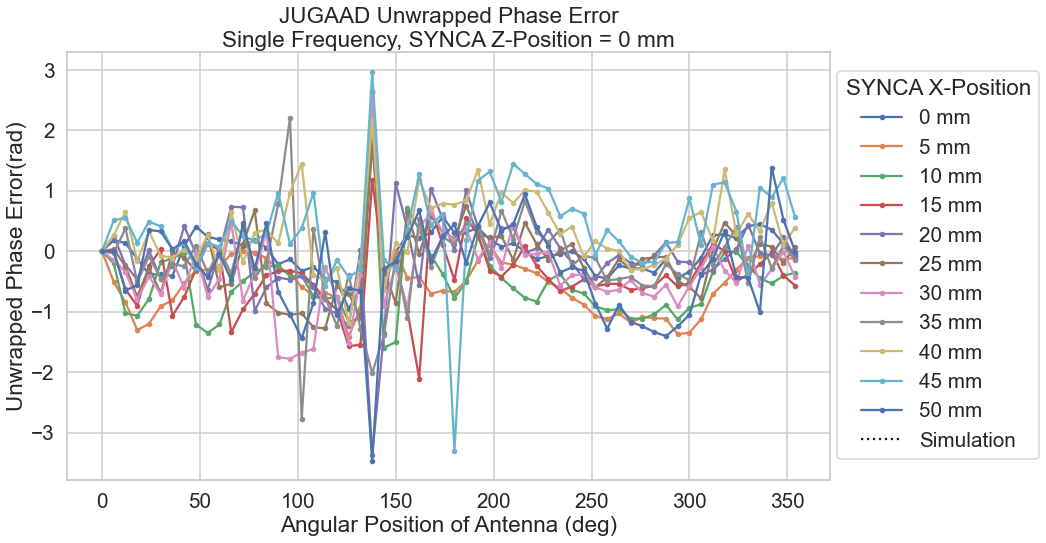

In [14]:
radii = np.arange(0, 55, 5)
test_axial_position = 0

clist = sns.color_palette('deep', n_colors=11)
sns.set_theme(context='talk', style='whitegrid', font_scale=1.25)
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,1,1)
for k, rad in enumerate(radii):
    if rad<10:
        test_key_rad = f'r0{rad}'
    else:
        test_key_rad = f'r{rad}'
    
    if test_axial_position < 10:
        test_key_axial = f'z0{test_axial_position}'
    else:
        test_key_axial = f'z{test_axial_position}'
        
    test_key = test_key_rad + test_key_axial
    test_data = jugaad_data[test_key][:]
    test_position = np.array([[0.001 * rad, 0.],])
    # loop over frequencies
    for i, n in enumerate([76]):#enumerate(np.arange(0,test_data.shape[1],1)):

        test_phases = np.unwrap(np.angle(test_data[:,n,1,0]), axis=0)
        test_phases -= test_phases[0]


        phase_correction = phase_offset_correction(test_phases, PhaseModel(60, test_position)[:,0,0])
        test_phases = test_phases + phase_correction
        phase_correction = phase_offset_correction(test_phases, PhaseModel(60, test_position)[:,0,0])
        test_phases = test_phases + phase_correction
        phase_correction = phase_offset_correction(test_phases, PhaseModel(60, test_position)[:,0,0])
        test_phases = test_phases + phase_correction

        differences = test_phases - PhaseModel(60, test_position)[:,0,0]
        for j in range(differences.size):
            if abs(differences[j]) > 3.5:
                while(abs(differences[j]) > 3.5):
                    differences[j] -= np.sign(differences[j])*2*np.pi

        ax.plot(np.arange(0,360,6),differences, ls='-', marker='.', color=clist[k%11], label=f'{radii[k]} mm')
        #ax.plot(np.arange(0,360,6),PhaseModel(60,test_position)[:,0,0],ls=':',marker='None',color='k')
ax.plot([],[],label='Simulation',color='k',ls=':',marker='None')
ax.legend(title='SYNCA X-Position', loc=(1.01,0.05))
ax.set_xlabel('Angular Position of Antenna (deg)')
ax.set_ylabel('Unwrapped Phase Error(rad)')
ax.set_title('JUGAAD Unwrapped Phase Error'+'\n'+f'Single Frequency, SYNCA Z-Position = {test_axial_position} mm')

plt.tight_layout(pad=1.05)
plt.savefig(Path.home()/'iCloud'/'plots'/'230116_jugaad_phase_error', dpi=128)

# save phase errors

In [15]:
print(np.arange(0,55,5), np.arange(0,30,5))

[ 0  5 10 15 20 25 30 35 40 45 50] [ 0  5 10 15 20 25]


In [16]:
file_repo = Path.home()/'iCloud'/'jugaad_data'/'Characterization'
file_name = '230113_phase_errors.npy'

In [17]:
radii = np.arange(0, 55, 5)
axial_positions = np.arange(0, 30, 5)
phase_errors = np.zeros((6, 11, 141, 60))


for i_ax, ax in enumerate(axial_positions):
    for i_rad, rad in enumerate(radii):

        if rad<10:
            test_key_rad = f'r0{rad}'
        else:
            test_key_rad = f'r{rad}'

        if ax < 10:
            test_key_axial = f'z0{ax}'
        else:
            test_key_axial = f'z{ax}'

        test_key = test_key_rad + test_key_axial
        test_data = jugaad_data[test_key][:]
        test_position = np.array([[0.001 * rad, 0.],])
        # loop over frequencies
        for i, n in enumerate(np.arange(0,test_data.shape[1],1)):

            test_phases = np.unwrap(np.angle(test_data[:,n,0,1]), axis=0)
            test_phases -= test_phases[0]

            phase_correction = phase_offset_correction(test_phases, PhaseModel(60, test_position)[:,0,0])
            test_phases = test_phases + phase_correction
            phase_correction = phase_offset_correction(test_phases, PhaseModel(60, test_position)[:,0,0])
            test_phases = test_phases + phase_correction
            phase_correction = phase_offset_correction(test_phases, PhaseModel(60, test_position)[:,0,0])
            test_phases = test_phases + phase_correction

            differences = test_phases - PhaseModel(60, test_position)[:,0,0]
            for j in range(differences.size):
                if abs(differences[j]) > 3.5:
                    while(abs(differences[j]) > 3.5):
                        differences[j] -= np.sign(differences[j])*2*np.pi
                        
            phase_errors[i_ax, i_rad, i, :] = differences

np.save(file_repo/file_name, phase_errors)